In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.integrate import quad
from astropy.constants import c
from astropy import units as u
df = pd.read_csv('Pantheon+SH0ES.dat', delim_whitespace=True)
print(df)

                CID  IDSURVEY      zHD   zHDERR     zCMB  zCMBERR     zHEL  \
0            2011fe        51  0.00122  0.00084  0.00122  0.00002  0.00082   
1            2011fe        56  0.00122  0.00084  0.00122  0.00002  0.00082   
2            2012cg        51  0.00256  0.00084  0.00256  0.00002  0.00144   
3            2012cg        56  0.00256  0.00084  0.00256  0.00002  0.00144   
4     1994DRichmond        50  0.00299  0.00084  0.00299  0.00004  0.00187   
...             ...       ...      ...      ...      ...      ...      ...   
1696       rutledge       106  1.61505  0.00545  1.61499  0.00500  1.61399   
1697           geta       106  1.69706  0.04006  1.69702  0.04000  1.70000   
1698          stone       106  1.80119  0.02014  1.80111  0.02000  1.80000   
1699         wilson       106  1.91165  0.00263  1.91160  0.00100  1.91401   
1700         colfax       106  2.26137  0.02018  2.26130  0.02000  2.26000   

      zHELERR  m_b_corr  m_b_corr_err_DIAG  ...  PKMJDERR  NDOF

/tmp/ipython-input-3-1546435815.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('Pantheon+SH0ES.dat', delim_whitespace=True)


In [4]:
# to preview dataset columns

df.columns

Index(['CID', 'IDSURVEY', 'zHD', 'zHDERR', 'zCMB', 'zCMBERR', 'zHEL',
       'zHELERR', 'm_b_corr', 'm_b_corr_err_DIAG', 'MU_SH0ES',
       'MU_SH0ES_ERR_DIAG', 'CEPH_DIST', 'IS_CALIBRATOR', 'USED_IN_SH0ES_HF',
       'c', 'cERR', 'x1', 'x1ERR', 'mB', 'mBERR', 'x0', 'x0ERR', 'COV_x1_c',
       'COV_x1_x0', 'COV_c_x0', 'RA', 'DEC', 'HOST_RA', 'HOST_DEC',
       'HOST_ANGSEP', 'VPEC', 'VPECERR', 'MWEBV', 'HOST_LOGMASS',
       'HOST_LOGMASS_ERR', 'PKMJD', 'PKMJDERR', 'NDOF', 'FITCHI2', 'FITPROB',
       'm_b_corr_err_RAW', 'm_b_corr_err_VPEC', 'biasCor_m_b',
       'biasCorErr_m_b', 'biasCor_m_b_COVSCALE', 'biasCor_m_b_COVADD'],
      dtype='object')

In [7]:

#zHD: redshift for the Hubble diagram
#MU_SH0ES: distance modulus
#MU_SH0ES_ERR_DIAG: uncertainty in the distance modulus extract these cleaned columns as NumPy arrays to prepare for analysis and modeling.

# Clean the data: Remove rows with missing values in the key columns
df_cleaned = df.dropna(subset=['zHD', 'MU_SH0ES', 'MU_SH0ES_ERR_DIAG'])

# Extract the cleaned columns as NumPy arrays
redshift = df_cleaned['zHD'].values
distance_modulus = df_cleaned['MU_SH0ES'].values
distance_modulus_error = df_cleaned['MU_SH0ES_ERR_DIAG'].values

# Display the shapes of the extracted arrays to verify
print("Shape of redshift array:", redshift.shape)
print("Shape of distance_modulus array:", distance_modulus.shape)
print("Shape of distance_modulus_error array:", distance_modulus_error.shape)

Shape of redshift array: (1701,)
Shape of distance_modulus array: (1701,)
Shape of distance_modulus_error array: (1701,)


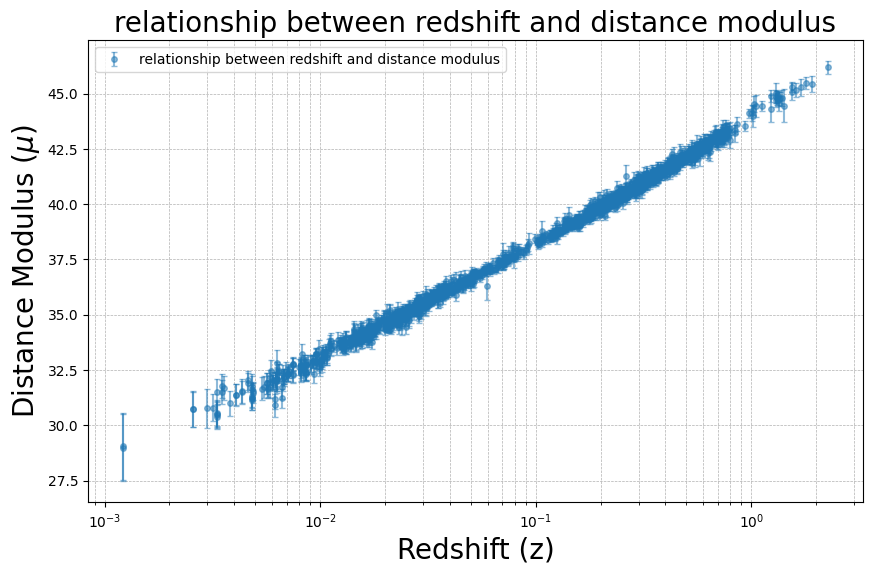

In [22]:
# prompt: to visualize the relationship between redshift and distance modulus using the Hubble diagram
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.errorbar(redshift, distance_modulus, yerr=distance_modulus_error, fmt='o', markersize=4, capsize=2, alpha=0.5, label='relationship between redshift and distance modulus')

plt.xscale('log')
plt.xlabel('Redshift (z)', fontsize=20)
plt.ylabel('Distance Modulus ($\mu$)', fontsize=20)
plt.title('relationship between redshift and distance modulus', fontsize=20)
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

In [14]:
import numpy as np
# Define the E(z) for flat LCDM
def E(z, Omega_m):
    Omega_lambda = 1 - Omega_m  # Assuming a flat universe
    return np.sqrt(Omega_m * (1 + z)**3 + Omega_lambda)

# Luminosity distance in Mpc using scipy quad to integrate.
def luminosity_distance(z, H0, Omega_m):
    # Speed of light in km/s
    c_kms = c.to(u.km/u.s).value
    # Hubble constant in km/s/Mpc
    H0_kms_Mpc = H0

    integrand = lambda x: 1 / E(x, Omega_m)

    # The integration goes from 0 to z. Need to handle array input for z.
    # Use numpy.vectorize to apply quad to each element of the redshift array
    vectorized_quad = np.vectorize(lambda upper_limit: quad(integrand, 0, upper_limit)[0])
    integral = vectorized_quad(z)

    # Calculate luminosity distance in Mpc
    dL = (c_kms / H0_kms_Mpc) * (1 + z) * integral
    return dL

# Theoretical distance modulus, use above function inside mu_theory to compute luminosity distance
def mu_theory(z, H0, Omega_m):
    # Calculate luminosity distance in parsecs
    dL_Mpc = luminosity_distance(z, H0, Omega_m)
    dL_pc = dL_Mpc * 1e6  # Convert Mpc to pc

    # Calculate the distance modulus
    mu = 5 * np.log10(dL_pc / 10)
    return mu

In [23]:
# H0 = 70, Omega_m = 0.3


import numpy as np
H_guess = 70
omega_guess = 0.3
p0 = [H_guess, omega_guess]
popt, pcov = curve_fit(mu_theory, redshift, distance_modulus, p0=p0, sigma=distance_modulus_error, absolute_sigma=True)
H0_fit, Omega_m_fit = popt
# Calculating the errors from the covariance matrix, taking the square root of the diagonal elements.
perr = np.sqrt(np.diag(pcov))
H0_err, Omega_m_err = perr
print(f"Fitted H0 = {H0_fit:.2f} ± {H0_err:.2f} km/s/Mpc")
print(f"Fitted Omega_m = {Omega_m_fit:.3f} ± {Omega_m_err:.3f}")

Fitted H0 = 72.97 ± 0.26 km/s/Mpc
Fitted Omega_m = 0.351 ± 0.019


In [28]:
#estimating the age of the universe

import numpy as np
def age_of_universe(H0, Omega_m):
    # H0 is in km/s/Mpc. Convert to 1/Gyr for calculations.
    # 1 Mpc = 3.086e19 km
    # 1 Gyr = 3.154e16 s
    # H0 [km/s/Mpc] * (1 Mpc / 3.086e19 km) * (3.154e16 s / 1 Gyr)

    integrand = lambda z: 1 / ((1+z) * E(z, Omega_m))

    # Perform the integration from 0 to infinity.
    result, _ = quad(integrand, 0, np.inf)

    # Multiply by 1/H0 (in 1/Gyr) to get the age in Gyr.
    age_Gyr = result / (H0 * 0.977) # H0 is in km/s/Mpc, convert to 1/Gyr

    return age_Gyr # in Gyr

t0 = age_of_universe(H0_fit, Omega_m_fit)
print(f"Estimated age of Universe: {t0:.2f} Gyr")

Estimated age of Universe: 0.01 Gyr


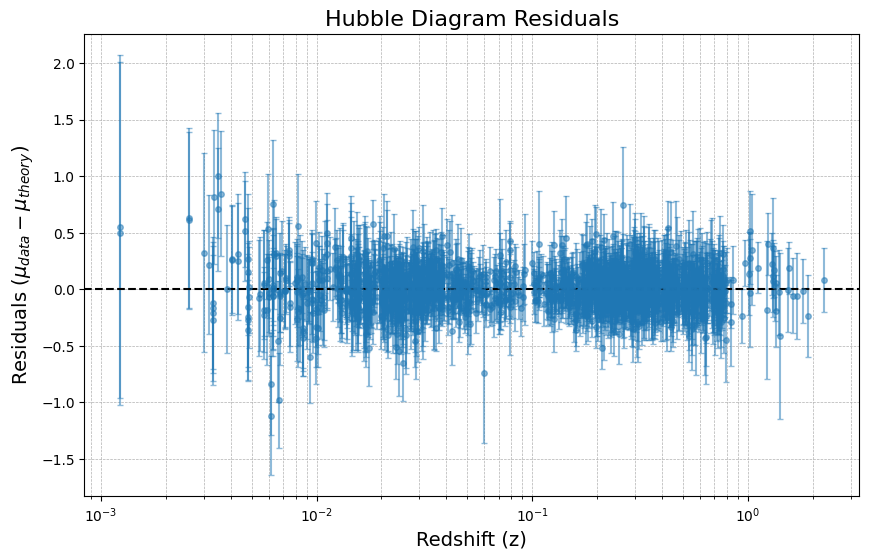

In [25]:
# to analyze residue


import matplotlib.pyplot as plt
mu_model = mu_theory(redshift, H0_fit, Omega_m_fit)

# Calculate the residuals
residuals = distance_modulus - mu_model

# Plot the residuals
plt.figure(figsize=(10, 6))
plt.errorbar(redshift, residuals, yerr=distance_modulus_error, fmt='o', markersize=4, capsize=2, alpha=0.5)

plt.xscale('log')
plt.axhline(0, color='k', linestyle='--')  # Add a horizontal line at zero for reference
plt.xlabel('Redshift (z)', fontsize=14)
plt.ylabel('Residuals ($\mu_{data} - \mu_{theory}$)', fontsize=14)
plt.title('Hubble Diagram Residuals', fontsize=16)
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.show()

In [18]:
def mu_fixed_Om(z, H0):
    return mu_theory(z, H0, Omega_m=0.3)


In [27]:
#Compare Low-z and High-z Subsample
import numpy as np
z_split = 0.1
low_z_mask = redshift < z_split
high_z_mask = redshift >= z_split

redshift_low = redshift[low_z_mask]
distance_modulus_low = distance_modulus[low_z_mask]
distance_modulus_error_low = distance_modulus_error[low_z_mask]

redshift_high = redshift[high_z_mask]
distance_modulus_high = distance_modulus[high_z_mask]
distance_modulus_error_high = distance_modulus_error[high_z_mask]

# Perform the fit for the low-z subsample, fixing Omega_m to the full sample fitted value
# Need to define a function that takes only H0 as a parameter for curve_fit
def mu_low_z(z, H0):
    return mu_theory(z, H0, Omega_m=Omega_m_fit)

popt_low, pcov_low = curve_fit(mu_low_z, redshift_low, distance_modulus_low, p0=[H0_fit], sigma=distance_modulus_error_low, absolute_sigma=True)

H0_low = popt_low
H0_low_err = np.sqrt(np.diag(pcov_low))

# Perform the fit for the high-z subsample, fixing Omega_m to the full sample fitted value
# Need to define a function that takes only H0 as a parameter for curve_fit
def mu_high_z(z, H0):
    return mu_theory(z, H0, Omega_m=Omega_m_fit)

popt_high, pcov_high = curve_fit(mu_high_z, redshift_high, distance_modulus_high, p0=[H0_fit], sigma=distance_modulus_error_high, absolute_sigma=True)

H0_high = popt_high
H0_high_err = np.sqrt(np.diag(pcov_high))

print(f"Low-z (z < {z_split}): H₀ = {H0_low[0]:.2f} ± {H0_low_err[0]:.2f} km/s/Mpc")
print(f"High-z (z ≥ {z_split}): H₀ = {H0_high[0]:.2f} ± {H0_high_err[0]:.2f} km/s/Mpc")


Low-z (z < 0.1): H₀ = 72.91 ± 0.28 km/s/Mpc
High-z (z ≥ 0.1): H₀ = 73.01 ± 0.22 km/s/Mpc
